## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Dataset Loading

In [ ]:
# census_data = pd.read_csv('/content/acs2017_county_data.csv')
census_data=pd.read_csv("acs2017_county_data.csv")
census_data['County'] = census_data['County'].str.replace(' County', '')
pollution_data = pd.read_csv("pollution_2000_2021.csv")

In [ ]:
merged_data = pd.merge(census_data, pollution_data, on=['County'], how='inner')
merged_data.head()

,CountyId,State_x,County,TotalPop_x,Men_x,Women_x,Hispanic_x,White_x,Black_x,Native_x,...,Walk_y,OtherTransp_y,WorkAtHome_y,MeanCommute_y,Employed_y,PrivateWork_y,PublicWork_y,SelfEmployed_y,FamilyWork_y,Unemployment_y
0,11001,District of Columbia,District of Columbia,672391,319046,353345,10.7,36.0,46.9,0.2,...,21.1,12.9,13.8,25.3,3172,75.8,18.4,5.2,0.7,5.1
1,11001,District of Columbia,District of Columbia,672391,319046,353345,10.7,36.0,46.9,0.2,...,76.6,7.0,8.3,11.2,1324,95.5,2.3,0.0,2.1,6.4
2,11001,District of Columbia,District of Columbia,672391,319046,353345,10.7,36.0,46.9,0.2,...,34.8,6.3,6.6,21.3,2567,78.8,14.8,6.0,0.4,3.1
3,11001,District of Columbia,District of Columbia,672391,319046,353345,10.7,36.0,46.9,0.2,...,18.3,4.0,7.8,25.0,4283,78.4,18.3,3.3,0.0,2.9
4,11001,District of Columbia,District of Columbia,672391,319046,353345,10.7,36.0,46.9,0.2,...,12.8,4.1,20.8,24.6,749,67.4,20.0,12.6,0.0,0.7


In [ ]:
def determine_transportation_category(row):
    max_mode = max(row['Drive'], row['Carpool'], row['Transit'], row['Walk'], row['OtherTransp'])
    if max_mode == row['Drive']:
        return 'Driving'
    elif max_mode == row['Carpool']:
        return 'Carpooling'
    elif max_mode == row['Transit']:
        return 'Public Transit'
    elif max_mode == row['Walk']:
        return 'Walking'
    else:
        return 'Other'

merged_data['TransportationMode'] = merged_data.apply(determine_transportation_category, axis=1)
merged_data['TransportationMode'].unique()

In [ ]:
merged_data.isna().sum()

In [ ]:
merged_data = merged_data.dropna()

In [ ]:
merged_data.isna().sum()

CensusId          0
State_x           0
County            0
TotalPop_x        0
Men_x             0
                 ..
PrivateWork_y     0
PublicWork_y      0
SelfEmployed_y    0
FamilyWork_y      0
Unemployment_y    0
Length: 73, dtype: int64

In [ ]:
features = ['TotalPop', 'Men', 'Women', 'Income', 'Poverty', 'MeanCommute', 'O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']

target = 'TransportationMode'

X = merged_data[features]
y = merged_data[target]

X

### Visualization

In [ ]:
# Heatmap
data = merged_data[features]

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Selected Features')
plt.show()


In [ ]:
# Histogram of Income
variable = 'Income'

plt.figure(figsize=(8, 6))
plt.hist(merged_data[variable], bins=20, color='blue', alpha=0.7)
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.title(f'Histogram of {variable}')
plt.show()


In [ ]:
# Histogram of Transportation Mode

variable = 'TransportationMode'

plt.figure(figsize=(8, 6))
plt.hist(merged_data[variable], bins=20, color='blue', alpha=0.7)
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.title(f'Histogram of {variable}')
plt.show()


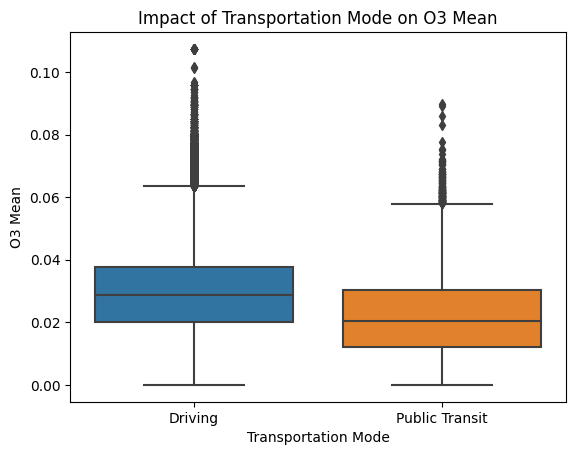

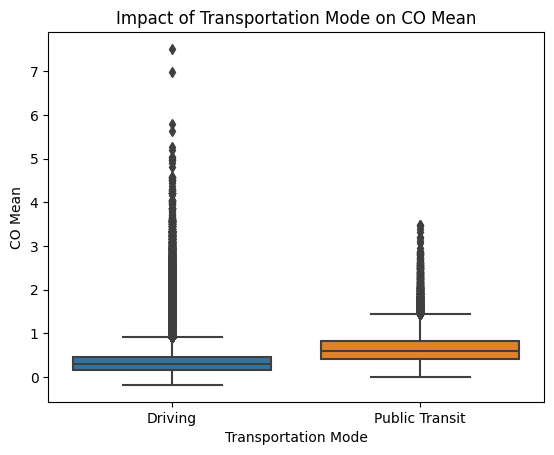

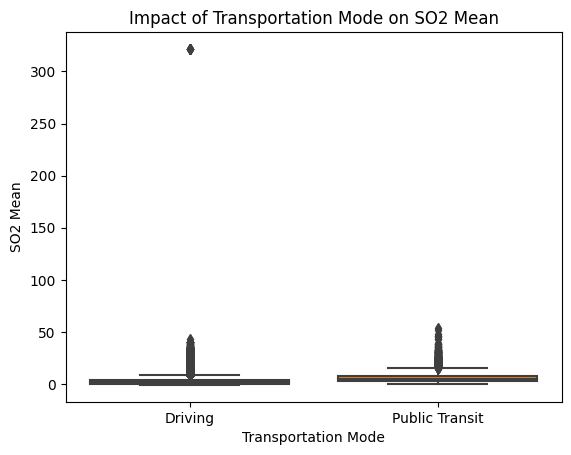

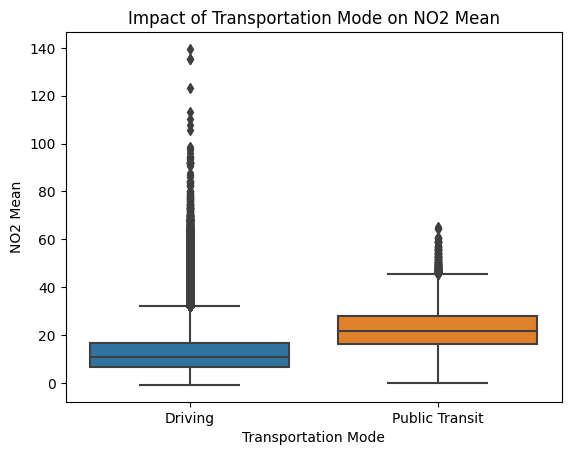

In [ ]:
variables = [ 'Transportation'O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean',Mode']

for variable in variables[:-1]:
    sns.boxplot(x='TransportationMode', y=variable, data=merged_data)
    plt.title(f'Impact of Transportation Mode on {variable}')
    plt.ylabel(variable)
    plt.xlabel('Transportation Mode')
    plt.show()


In [ ]:
# Perform ANOVA test
for variable in variables[:-1]:
    groups = [group[1] for group in merged_data.groupby('TransportationMode')[variable]]
    f_statistic, p_value = stats.f_oneway(*groups)
    print(f'ANOVA for {variable}: F-statistic = {f_statistic}')

ANOVA for O3 Mean: F-statistic = 3817.28964972015
ANOVA for CO Mean: F-statistic = 16287.933329826024
ANOVA for SO2 Mean: F-statistic = 12324.193281291482
ANOVA for NO2 Mean: F-statistic = 17729.01682553224


The F-statistic measures the ratio of the variance between groups (transportation modes) to the variance within groups. A high F-statistic indicates that there are significant differences in 'Variables' among different transportation modes. In other words,

1. Transportation modes have a least impact on 'O3 Mean'
2. Transportation modes have a strong impact 'CO Mean'.
3. Transportation modes have a significant impact on 'SO2 Mean'.
4. Transportation modes have a strong impact 'NO2 Mean'.

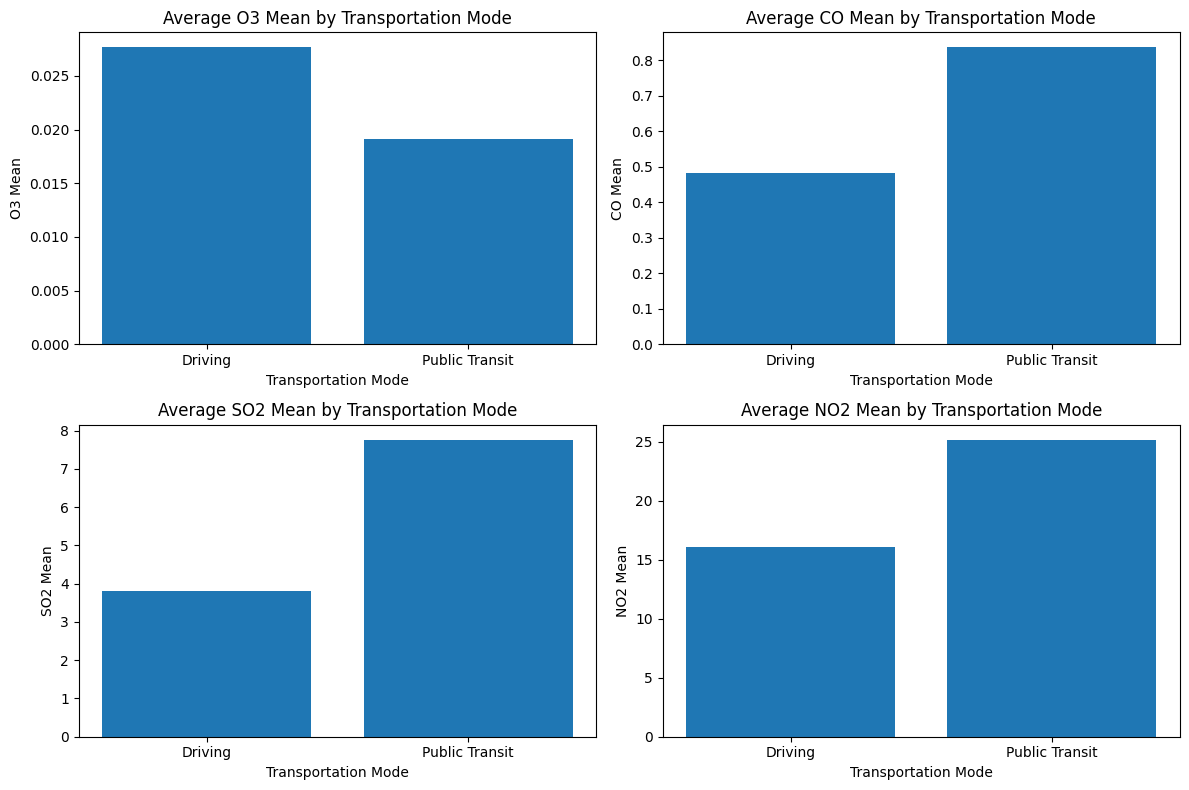

In [ ]:
pollution_variables = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']
transportation_modes = merged_data['TransportationMode'].unique()

average_pollution_by_mode = []
for mode in transportation_modes:
    mode_data = merged_data[merged_data['TransportationMode'] == mode][pollution_variables].mean()
    average_pollution_by_mode.append(mode_data)

plt.figure(figsize=(12, 8))
for i, variable in enumerate(pollution_variables):
    plt.subplot(2, 2, i+1)
    plt.bar(transportation_modes, [data[variable] for data in average_pollution_by_mode])
    plt.title(f'Average {variable} by Transportation Mode')
    plt.xlabel('Transportation Mode')
    plt.ylabel(variable)

plt.tight_layout()
plt.show()


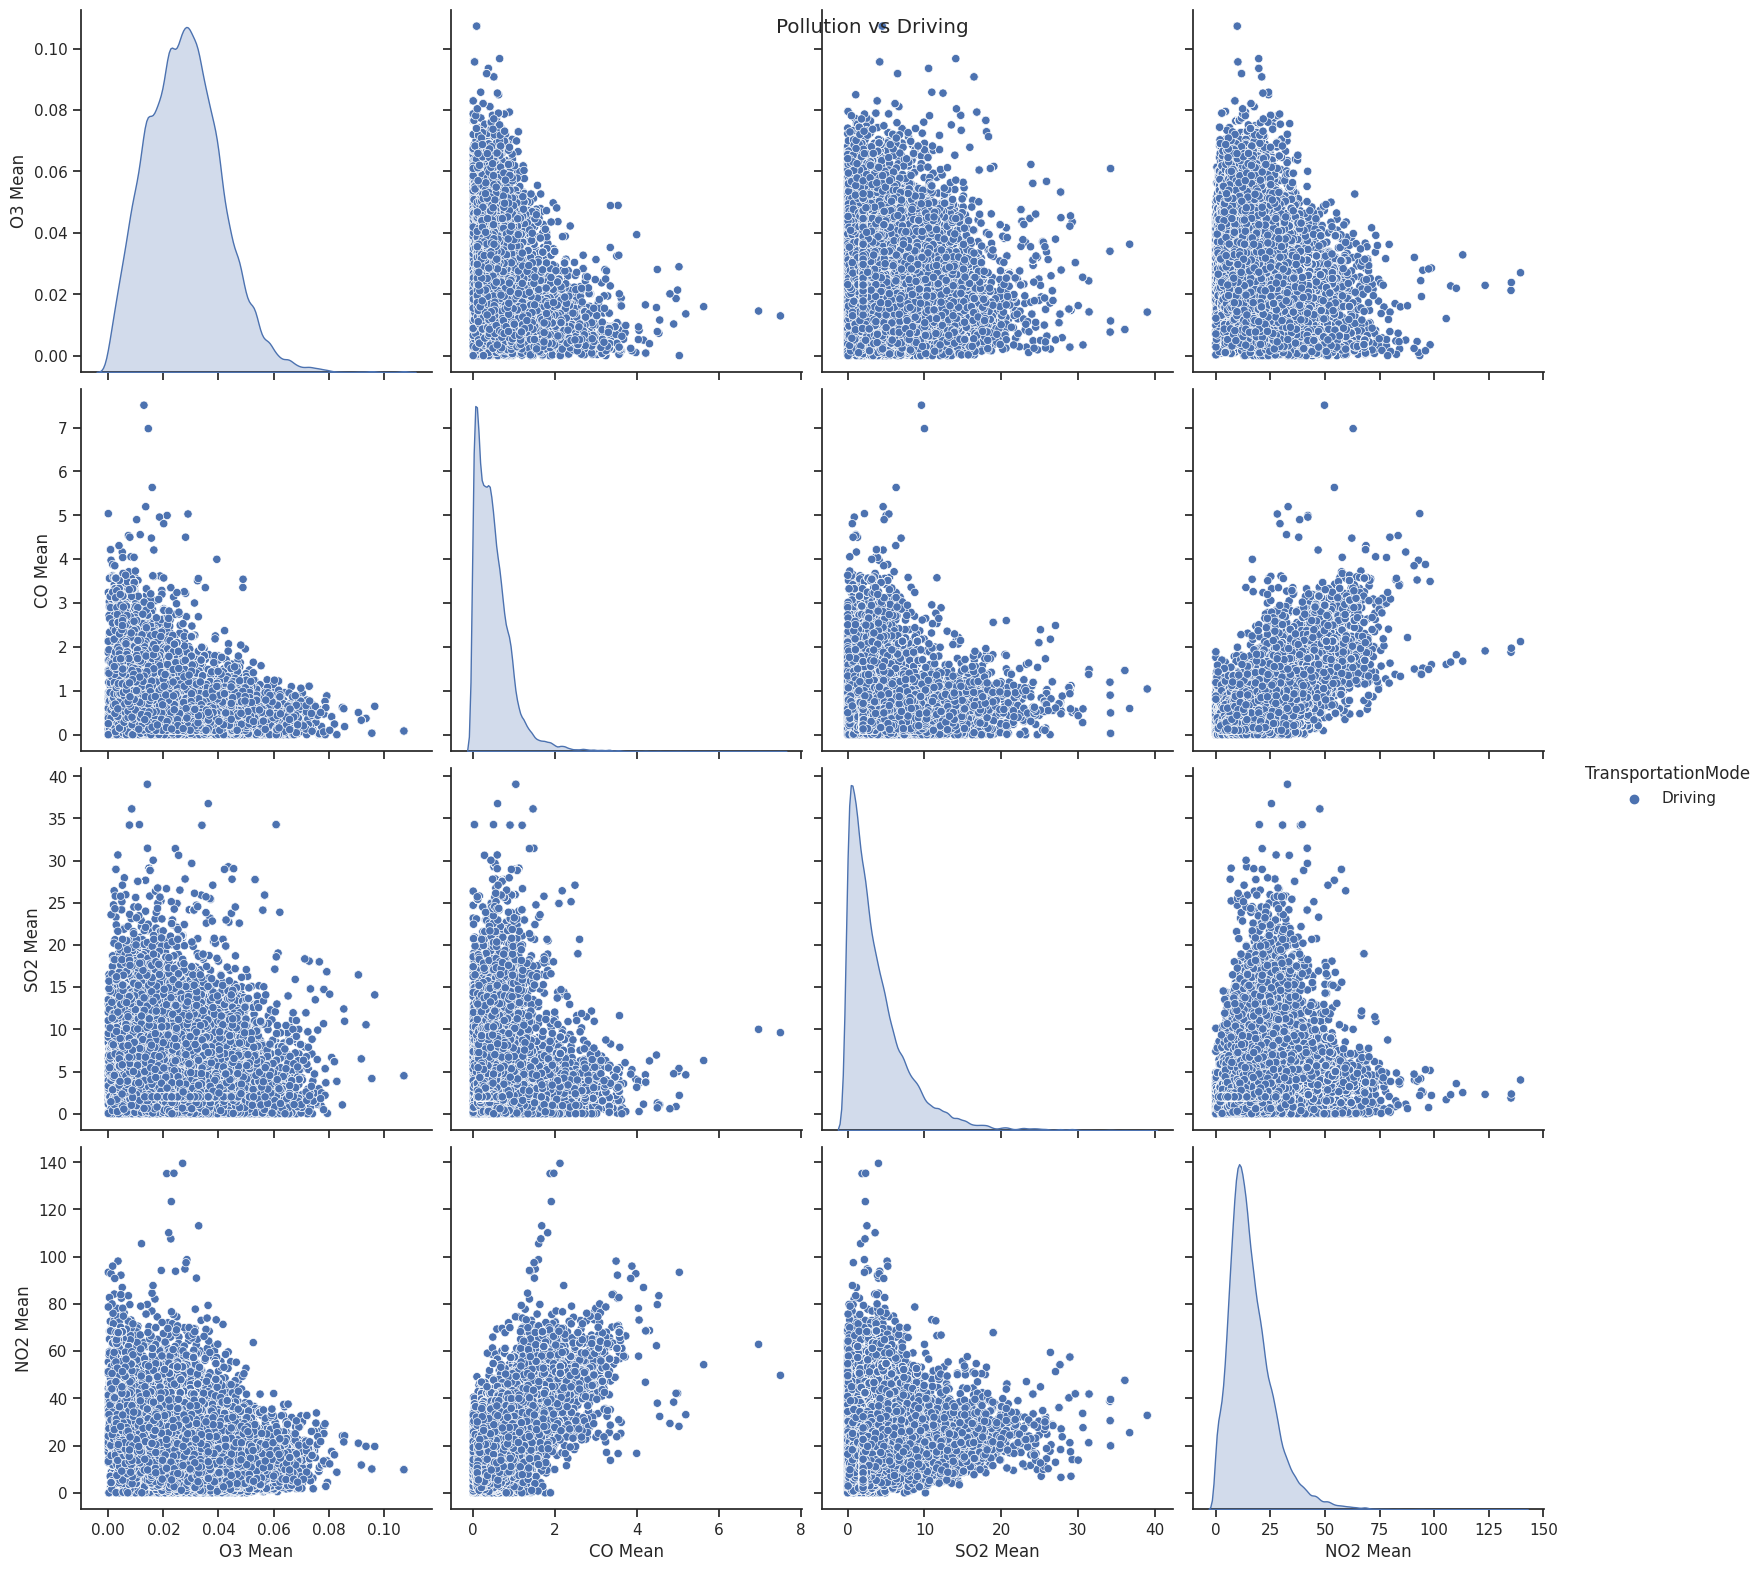

In [ ]:
pollution_variables = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']

specified_mode = 'Driving'

if specified_mode in merged_data['TransportationMode'].unique():
    sns.set(style="ticks")
    sns.pairplot(merged_data[merged_data['TransportationMode'] == specified_mode], x_vars=pollution_variables, y_vars=pollution_variables, kind="scatter", hue="TransportationMode", height=4)
    plt.suptitle(f'Pollution vs {specified_mode}')
    plt.show()
else:
    print(f"'{specified_mode}' is not found in the dataset.")


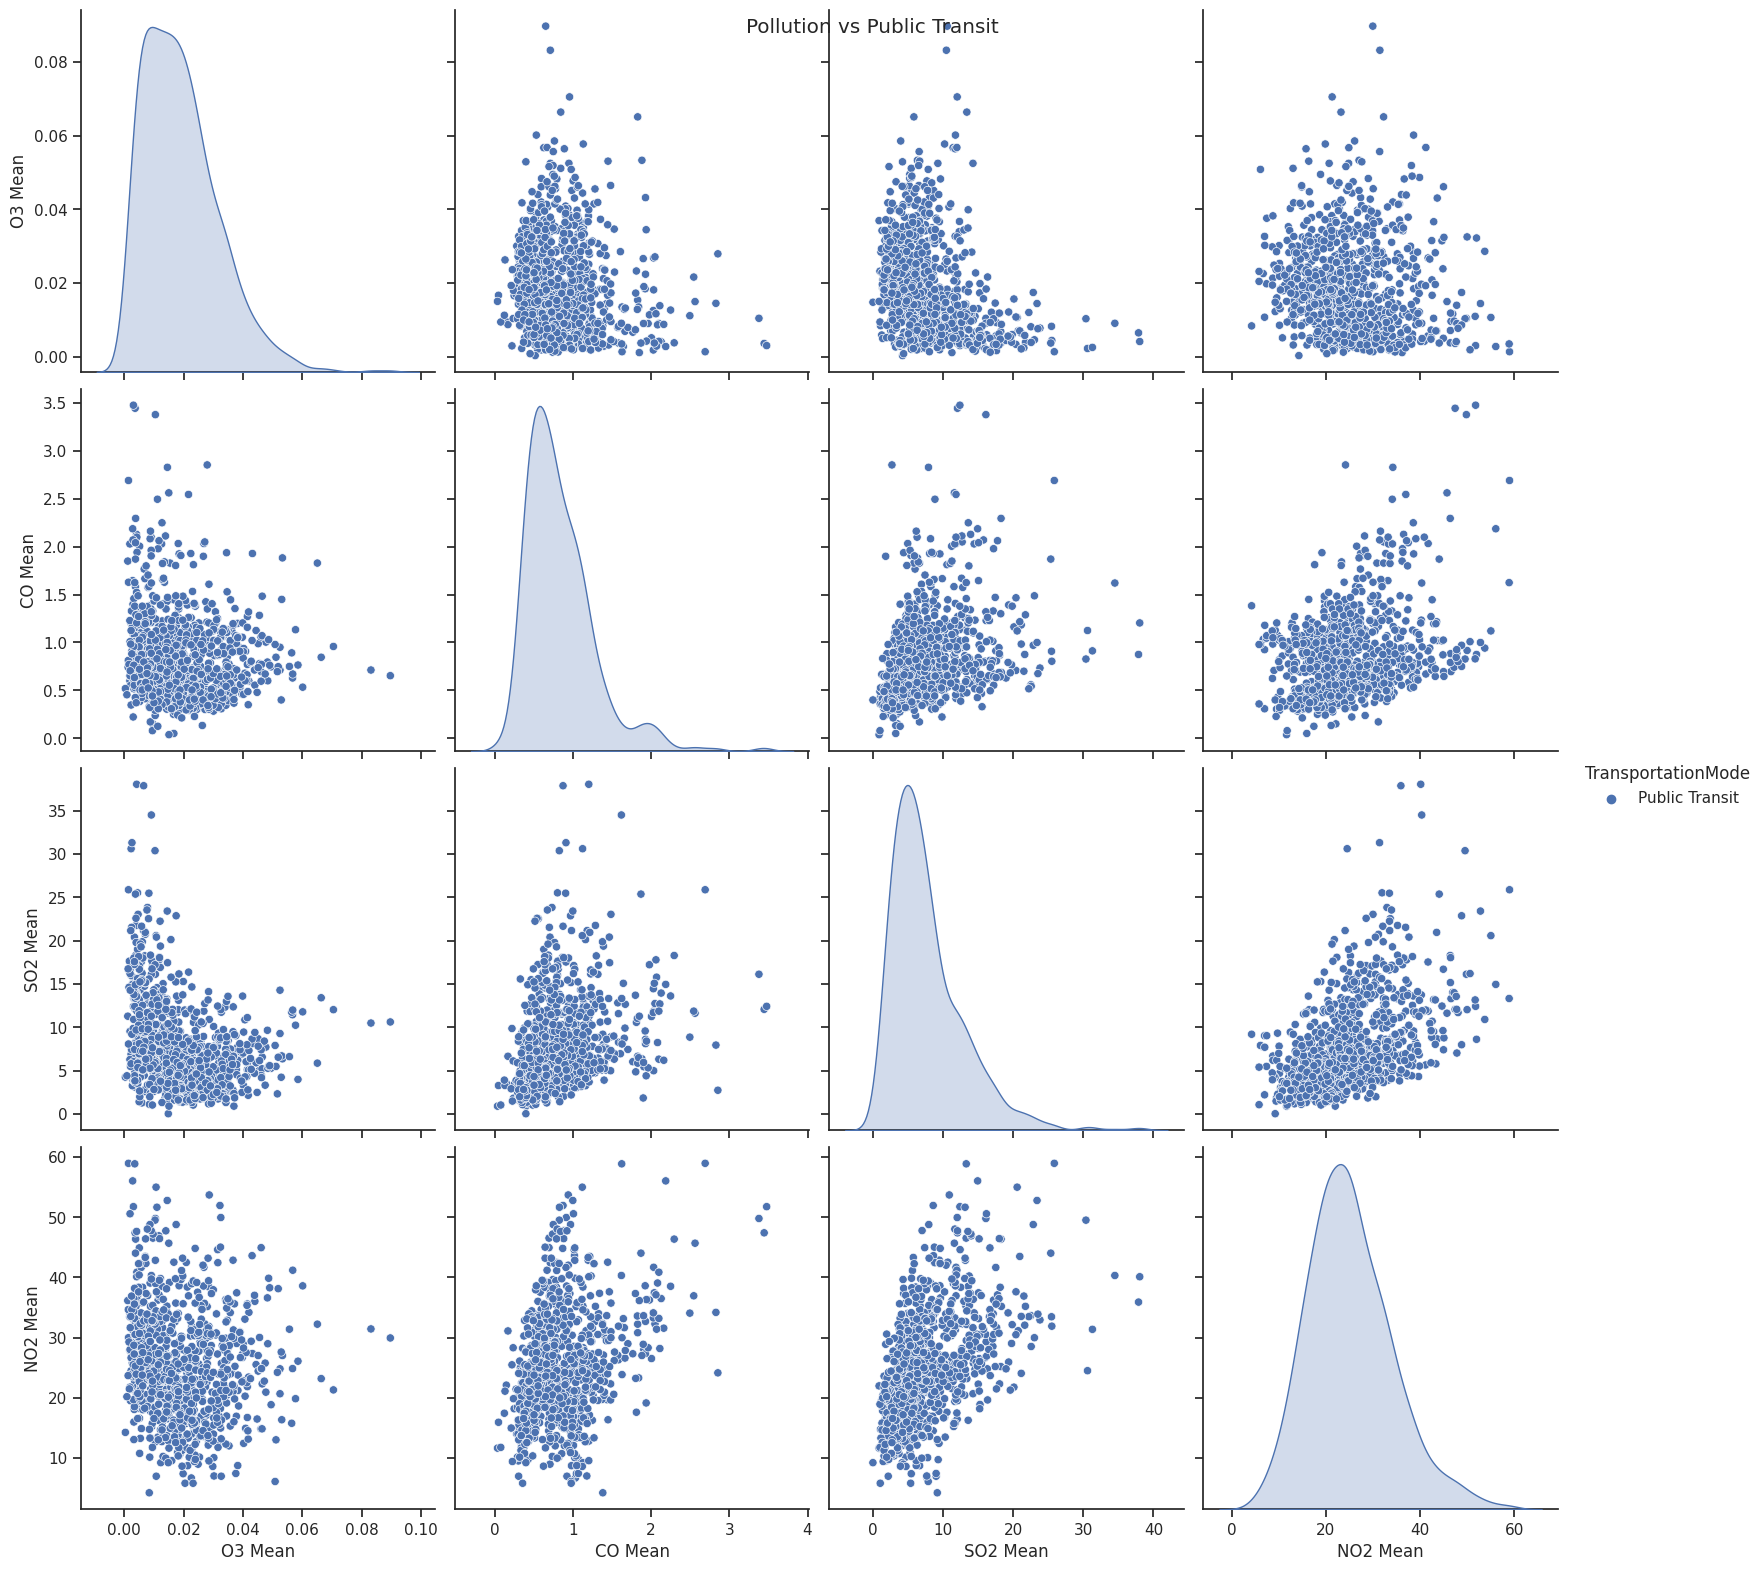

In [ ]:
pollution_variables = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']

specified_mode = 'Public Transit'

if specified_mode in merged_data['TransportationMode'].unique():
    sns.set(style="ticks")
    sns.pairplot(merged_data[merged_data['TransportationMode'] == specified_mode], x_vars=pollution_variables, y_vars=pollution_variables, kind="scatter", hue="TransportationMode", height=4)
    plt.suptitle(f'Pollution vs {specified_mode}')
    plt.show()
else:
    print(f"'{specified_mode}' is not found in the dataset.")

In [ ]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 1.0
                precision    recall  f1-score   support

       Driving       1.00      1.00      1.00    177156
Public Transit       1.00      1.00      1.00      2878

      accuracy                           1.00    180034
     macro avg       1.00      1.00      1.00    180034
  weighted avg       1.00      1.00      1.00    180034



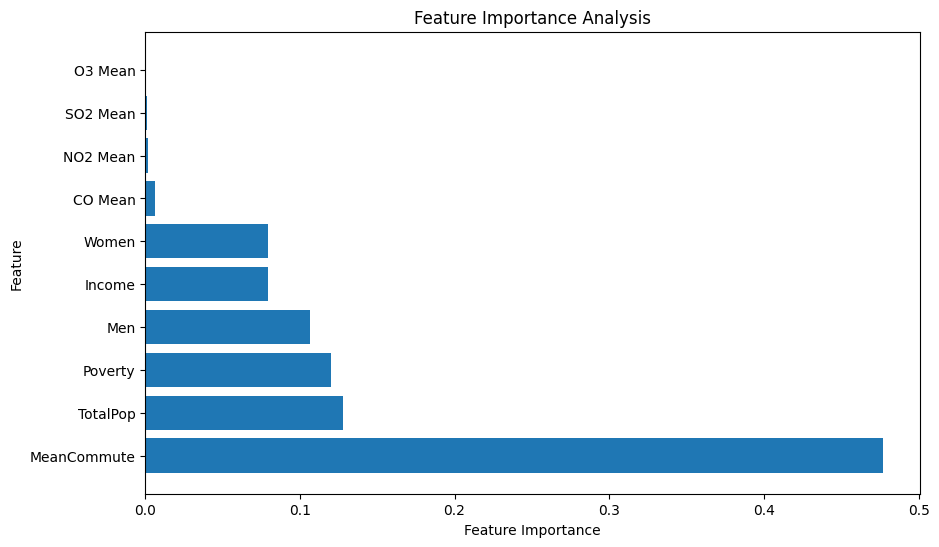

Feature Importance Rankings:
       Feature  Importance
5  MeanCommute    0.477151
0     TotalPop    0.128165
4      Poverty    0.120337
1          Men    0.106607
3       Income    0.079375
2        Women    0.079128
7      CO Mean    0.006226
9     NO2 Mean    0.001640
8     SO2 Mean    0.001372
6      O3 Mean    0.000000


In [ ]:
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.show()

print("Feature Importance Rankings:")
print(feature_importance_df)


In [ ]:
# Use Recursive Feature Elimination (RFE)
rfe = RFE(clf, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
# Train
clf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = clf.predict(X_test[selected_features])

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Reduced Features: {accuracy}")
report = classification_report(y_test, y_pred)
print(report)


Accuracy with Reduced Features: 1.0
                precision    recall  f1-score   support

       Driving       1.00      1.00      1.00    177156
Public Transit       1.00      1.00      1.00      2878

      accuracy                           1.00    180034
     macro avg       1.00      1.00      1.00    180034
  weighted avg       1.00      1.00      1.00    180034



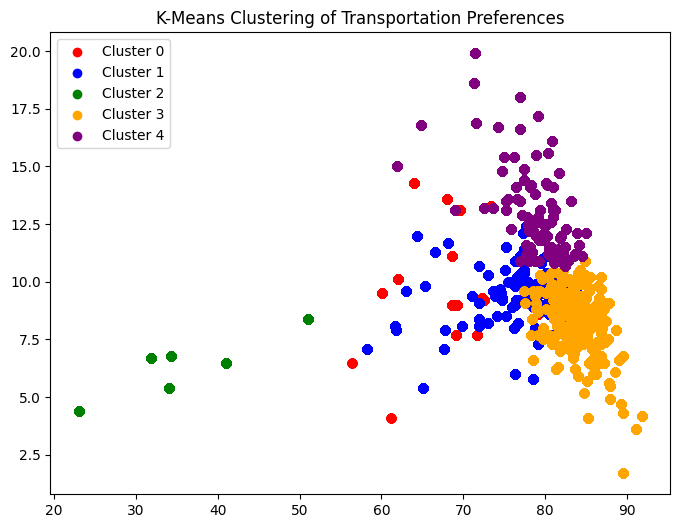

Cluster 0 - Numbers: 40091
Cluster 1 - Numbers: 285880
Cluster 2 - Numbers: 31089
Cluster 3 - Numbers: 363348
Cluster 4 - Numbers: 179760


In [ ]:
# Select the relevant features
cluster_features = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[cluster_features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clustering results
colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(8, 6))
for cluster_id in range(5):
    cluster_data = merged_data[merged_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data[cluster_features[0]], cluster_data[cluster_features[1]], c=colors[cluster_id], label=f'Cluster {cluster_id}')

plt.title('K-Means Clustering of Transportation Preferences')
plt.legend()
plt.show()

# Analyze the clustering results
for cluster_id in range(5):
    cluster_data = merged_data[merged_data['Cluster'] == cluster_id]
    print(f"Cluster {cluster_id} - Numbers: {len(cluster_data)}")

## Question # 5

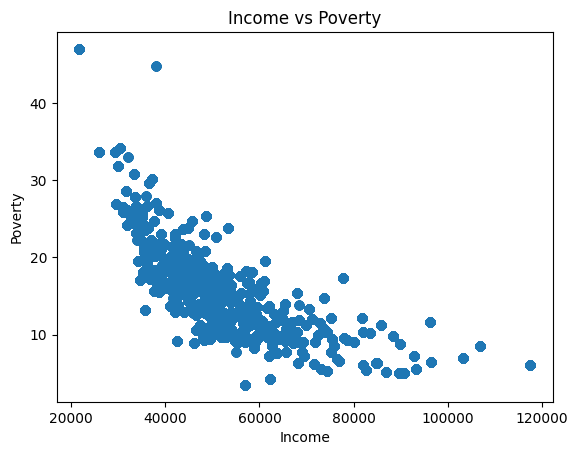

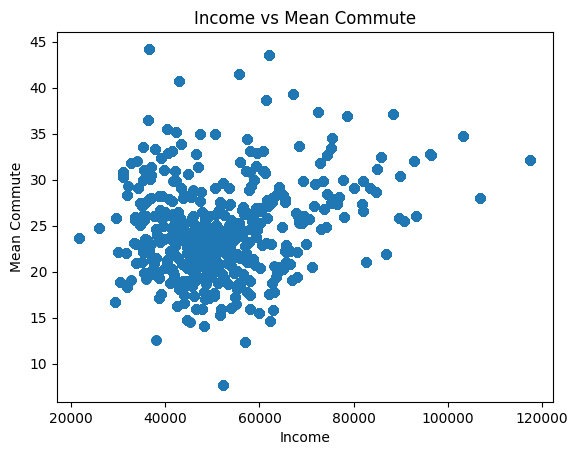

In [ ]:
# Create a scatter plot of income and poverty
plt.scatter(merged_data['Income'], merged_data['Poverty'])
plt.xlabel('Income')
plt.ylabel('Poverty')
plt.title('Income vs Poverty')
plt.show()

# Create a scatter plot of income and MeanCommute
plt.scatter(merged_data['Income'], merged_data['MeanCommute'])
plt.xlabel('Income')
plt.ylabel('Mean Commute')
plt.title('Income vs Mean Commute')
plt.show()



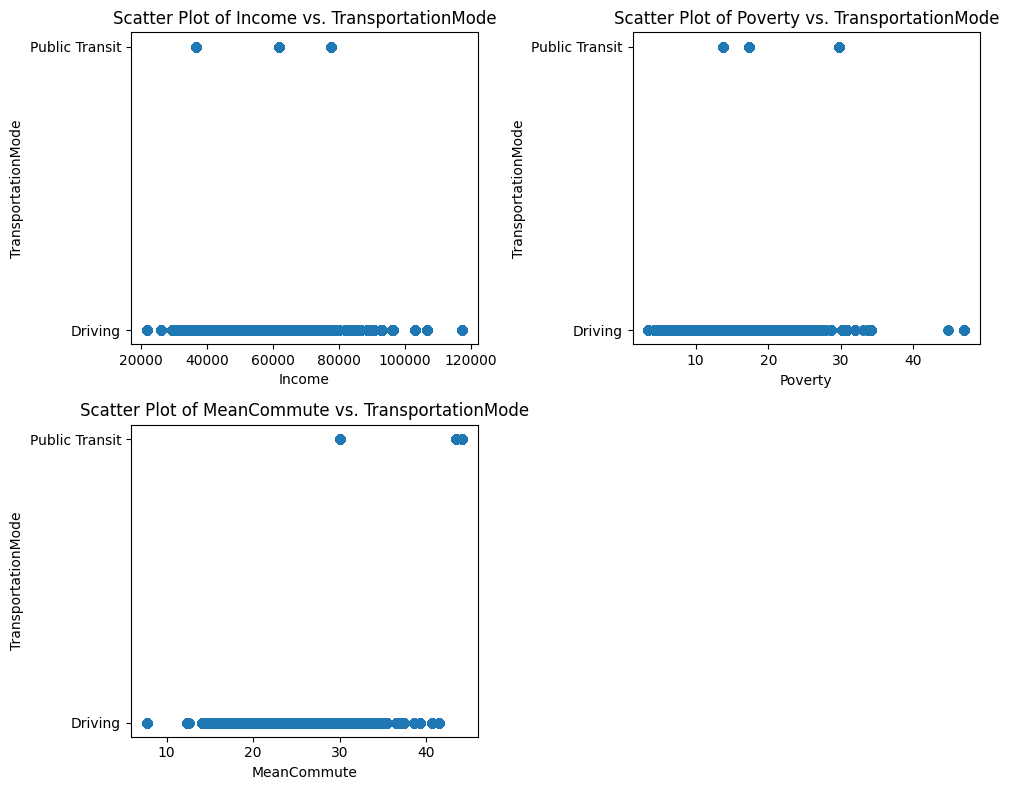

In [ ]:
# Select social and economic features
economic_features = ['Income', 'Poverty', 'MeanCommute']

# Visualization
plt.figure(figsize=(10, 8))

# Create scatter plots
for feature in economic_features:
    plt.subplot(2, 2, economic_features.index(feature) + 1)
    plt.scatter(merged_data[feature], merged_data['TransportationMode'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('TransportationMode')
    plt.title(f'Scatter Plot of {feature} vs. TransportationMode')

plt.tight_layout()
plt.show()


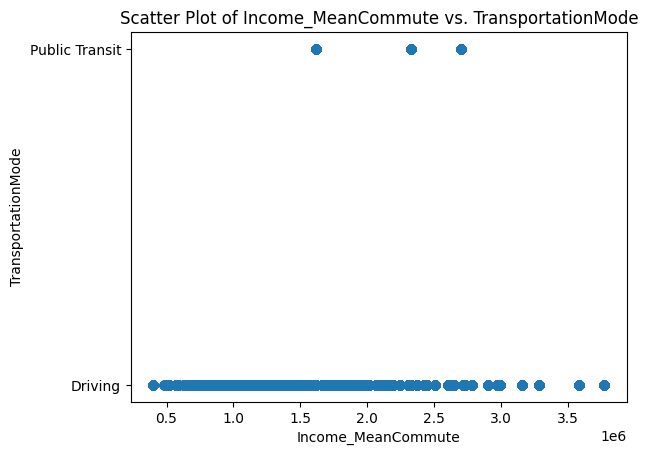

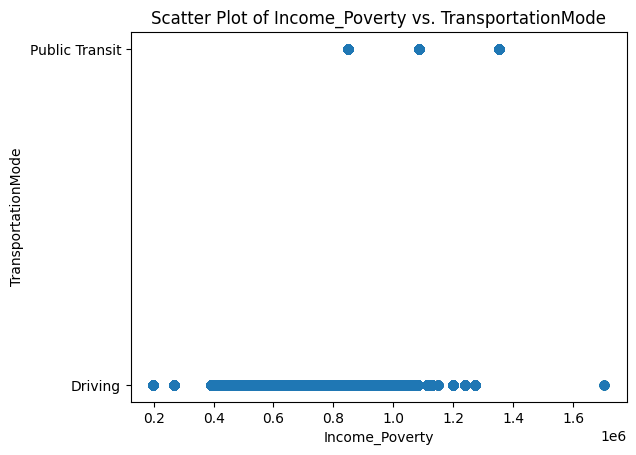

In [ ]:
# Create interaction terms
merged_data['Income_MeanCommute'] = merged_data['Income'] * merged_data['MeanCommute']
merged_data['Income_Poverty'] = merged_data['Income'] * merged_data['Poverty']

# Create scatter plots
plt.scatter(merged_data['Income_MeanCommute'], merged_data['TransportationMode'], alpha=0.5)
plt.xlabel('Income_MeanCommute')
plt.ylabel('TransportationMode')
plt.title('Scatter Plot of Income_MeanCommute vs. TransportationMode')
plt.show()

# Create scatter plots
plt.scatter(merged_data['Income_Poverty'], merged_data['TransportationMode'], alpha=0.5)
plt.xlabel('Income_Poverty')
plt.ylabel('TransportationMode')
plt.title('Scatter Plot of Income_Poverty vs. TransportationMode')
plt.show()